References: \
https://qiskit-community.github.io/qiskit-machine-learning/tutorials/02_neural_network_classifier_and_regressor.html \
https://github.com/qiskit-community/qiskit-machine-learning/tree/main/qiskit_machine_learning \
https://github.com/Qiskit/qiskit/tree/main/qiskit

In [1]:
from torch import manual_seed
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms

import cv2
import math

import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, transpile
import qiskit_algorithms
from qiskit_algorithms.optimizers import COBYLA, SPSA, GradientDescent
from qiskit_aer import Aer, AerSimulator
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.utils import algorithm_globals
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_distribution

from qiskit_ibm_runtime import (
    QiskitRuntimeService, 
    EstimatorV2 as Estimator,
    SamplerV2 as Sampler,
)
from qiskit.primitives import (
    StatevectorSampler,
    BackendSampler as BackendSampler,
    BackendSamplerV2 as BackendSamplerV2,
)

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN

# Set seed for random generators
algorithm_globals.random_seed = 42

In [2]:
#Training Dataset
# Set train shuffle seed (for reproducibility)
manual_seed(42)
num_classes = 2
# Perfect square number of qubits
num_qubits = 4
img_dim = int(math.sqrt(num_qubits))
# Samples per class
training_samples = 75
test_samples = 25

# Use pre-defined torchvision function to load MNIST train data
full_training_data = datasets.MNIST(
    root="./data", train=True, download=True, transform=transforms.Compose([transforms.Resize((img_dim, img_dim)),
                                                                            transforms.ToTensor()])
)

subset = []
for i in range(num_classes):
    idx = np.where(full_training_data.targets == i)[0][:training_samples]
    subset.extend(idx)

train = datasets.MNIST(
    root="./data", train=True, download=True, transform=transforms.Compose([transforms.Resize((img_dim, img_dim)),
                                                                             transforms.ToTensor()])
)

train.data = full_training_data.data[subset]
train.targets = full_training_data.targets[subset]

test = datasets.MNIST(
    root="./data", train=False, download=True, transform=transforms.Compose([transforms.Resize((img_dim, img_dim)),
                                                                             transforms.ToTensor()])
)

subset = []
for i in range(num_classes):
    idx = np.where(full_training_data.targets == i)[0][:test_samples]
    subset.extend(idx)
    
test.data = full_training_data.data[subset]
test.targets = full_training_data.targets[subset]

print("Train subset size:", len(train))
# print("Valid subset size:", len(valid))
print("Test subset size:", len(test))

def count(dataset):
    counter = {}
    features = []
    labels = []
    imgs = []
    for i in range(len(dataset)):
        im, class_idx = dataset[i]
        imgs.append(im)
        features.append(np.reshape(im, -1))
        one_hot = np.eye(num_classes)[class_idx]
        labels.append(one_hot)
        if class_idx not in counter:
            counter[class_idx] = 0
        counter[class_idx] += 1
    counter = dict(sorted(counter.items(), key=lambda x: x[0]))

    for key, value in counter.items():
        print(key, ":", value)
    return np.array(features), np.array(labels), np.array(imgs)
        
print("Training Dataset")
train_feats, train_labels, train_imgs = count(train)
indices = np.arange(train_feats.shape[0])
np.random.shuffle(indices)
train_feats = train_feats[indices]
train_labels = train_labels[indices]
train_imgs = train_imgs[indices]

print(train_feats.shape)
print(train_labels.shape)
print("\n")

print("Testing Dataset")
test_feats, test_labels, test_imgs = count(test)
indices = np.arange(test_feats.shape[0])
np.random.shuffle(indices)
test_feats = test_feats[indices]
test_labels = test_labels[indices]
test_imgs = test_imgs[indices]

print(test_feats.shape)
print(test_labels.shape)

Train subset size: 150
Test subset size: 50
Training Dataset
0 : 75
1 : 75
(150, 4)
(150, 2)


Testing Dataset
0 : 25
1 : 25
(50, 4)
(50, 2)


The training dataset has 150 images
After the shuffle the 0th image has class index 0
(2, 2, 1)
Image shape is (2, 2, 1)


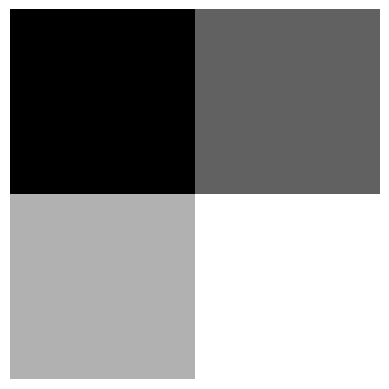

After the shuffle the 0th image has class index 0
(2, 2, 1)
Image shape is (2, 2, 1)


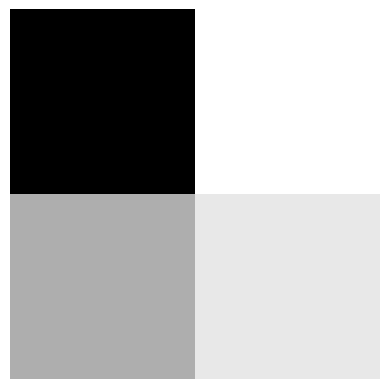

After the shuffle the 0th image has class index 0
(2, 2, 1)
Image shape is (2, 2, 1)


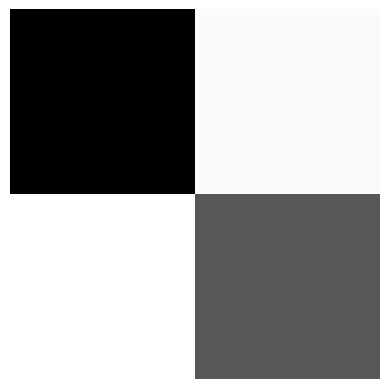

In [3]:
'''
Explore the constructed dataset
'''
import random
import matplotlib.pyplot as plt

# Find and output the number of images
n = len(train)
print(f'The training dataset has {n} images')

for i in range(3):
    # Randomly shuffle the image indices
    indices = list(range(n))
    random.shuffle(indices)

    # Get the image and the class id of the 0th image after the shuffle.
    im, class_idx = train[indices[0]]
    
    print(f'After the shuffle the 0th image has class index {class_idx}')

    # Convert the image from an array back to a numpy 3d array
    im_np = im.numpy().transpose((1, 2, 0))
    print(im_np.shape)
    print(f'Image shape is {im_np.shape}')

    # Display the image
    plt.imshow(im_np, cmap='gray')
    plt.axis('off')
    plt.show()

In [4]:
service = QiskitRuntimeService()
backend = service.backend("ibm_rensselaer")
fake_backend = AerSimulator.from_backend(backend)
print(backend)

num_qubits = len(train_feats[0])
print(num_qubits)

<IBMBackend('ibm_rensselaer')>
4


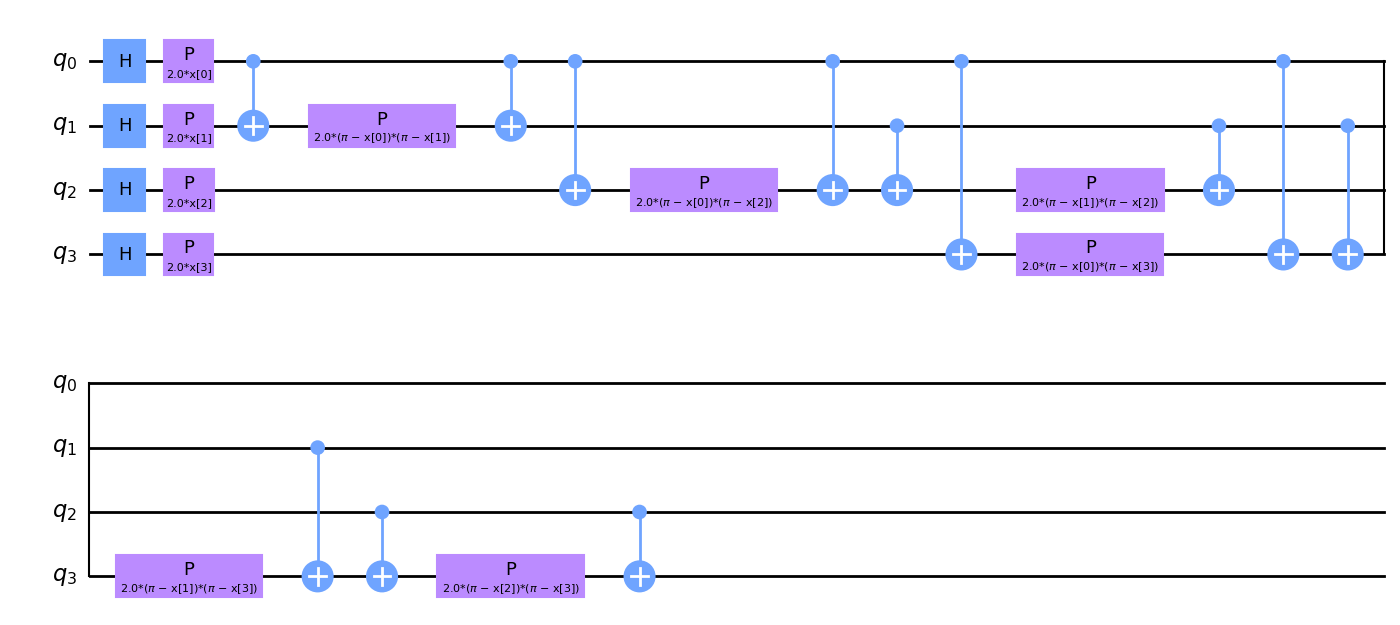

In [5]:
feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=1)
feature_map.decompose().draw(output="mpl", style="clifford", fold=20)

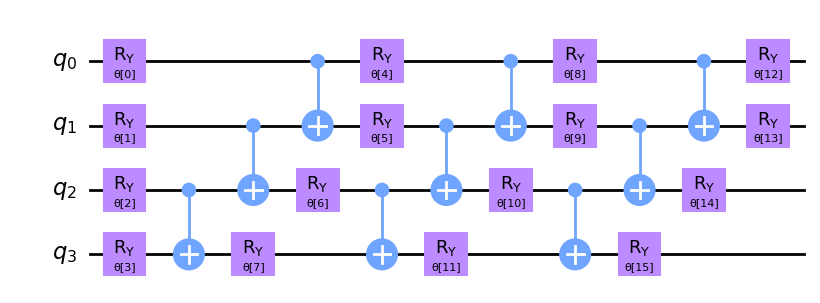

In [6]:
ansatz = RealAmplitudes(num_qubits=num_qubits, reps=3)
ansatz.decompose().draw(output="mpl", style="clifford", fold=20)

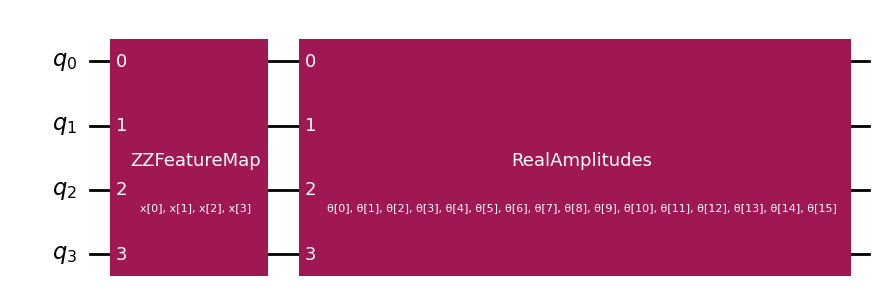

In [7]:
circuit = QuantumCircuit(num_qubits)
circuit.compose(feature_map, inplace=True)
circuit.compose(ansatz, inplace=True)
circuit.draw('mpl')

In [8]:
def parity(x):
    return "{:b}".format(x).count("1") % num_classes
    
sampler = BackendSampler(backend=fake_backend)

sampler_qnn = SamplerQNN(
    circuit=circuit,
    sampler=sampler,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    interpret=parity,
    output_shape=num_classes,
)

sampler_qnn_input = algorithm_globals.random.random(sampler_qnn.num_inputs)
sampler_qnn_weights = algorithm_globals.random.random(sampler_qnn.num_weights)

sampler_qnn_forward = sampler_qnn.forward(sampler_qnn_input, sampler_qnn_weights)
print(sampler_qnn_forward)

C:\Users\Chris\AppData\Local\Temp\ipykernel_28636\1699821699.py:4: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler = BackendSampler(backend=fake_backend)


[[0.62207031 0.37792969]]


In [9]:
# import time

# weights = []
# for i in range(50):
#     print(f"Epoch: {i}")
#     initial_weights = algorithm_globals.random.random(ansatz.num_parameters)
#     print(f"Initial weights: {initial_weights}")
    
#     classifier = NeuralNetworkClassifier(
#         neural_network=sampler_qnn,
#         loss="cross_entropy",
#         one_hot=True,
#         optimizer=COBYLA(maxiter=30),  #Default learning rate: 0.01
#         initial_point=initial_weights, 
#         callback=callback_graph
#     )


#     objective_func_vals = []
# # plt.rcParams["figure.figsize"] = (12, 6)

# # fit classifier to data
#     start = time.time()
#     classifier.fit(train_feats, train_labels)
#     elapsed = time.time() - start

    
    
# # return to default figsize
# # plt.rcParams["figure.figsize"] = (6, 4)
#     print(f"Training time: {round(elapsed)} seconds")
#     accuracy = classifier.score(test_feats, test_labels)
#     if accuracy > 0.7:
#         weights.append(initial_weights)
#         print(accuracy)
#         print("-------------------------------")

# weights = np.array(weights)

# np.save('2by2params.npy', weights)
# # print("Losses:", objective_func_vals)

In [10]:
import time

def callback(weights, obj_func_eval):
    objective_func_vals.append(obj_func_eval)


# Loading pre-saved initial weights to showcase importance of the starting point
initial_weights = np.load("2by2params.npy")
# print(f"Initial weights: {initial_weights}")

losses = []
for i, initial_point in enumerate(initial_weights):
    classifier = NeuralNetworkClassifier(
        neural_network=sampler_qnn,
        loss="cross_entropy",
        one_hot=True,
        optimizer=COBYLA(maxiter=30),  #Default learning rate: 0.01
        initial_point=initial_point, 
        callback=callback
    )
    
    objective_func_vals = []

    print(f"Weight {i}:")
    print(f"Initial weights: {initial_point}")
    
    # fit classifier to data
    start = time.time()
    classifier.fit(train_feats, train_labels)
    elapsed = time.time() - start
    
    losses.append(objective_func_vals)
    
    accuracy = classifier.score(test_feats, test_labels)

    print(f"Accuracy: {accuracy}")
    print(f"Trained weights: {classifier.weights}")
    print(f"Training time: {round(elapsed)} seconds")
    print("---------------------------------------")

Weight 0:
Initial weights: [0.12992151 0.47570493 0.22690935 0.66981399 0.43715192 0.8326782
 0.7002651  0.31236664 0.8322598  0.80476436 0.38747838 0.2883281
 0.6824955  0.13975248 0.1999082  0.00736227]
Accuracy: 0.94
Trained weights: [ 0.14137877  0.51039813  1.23253967  0.66499372  0.92589122  0.91889012
  0.46514795  1.32903094  0.81727314  0.59175709  0.52295621  1.29979384
  0.60679723  0.12402503  1.21781192 -0.02969539]
Training time: 106 seconds
---------------------------------------
Weight 1:
Initial weights: [0.03081783 0.43671739 0.21458467 0.40852864 0.85340307 0.23393949
 0.05830274 0.28138389 0.29359376 0.66191651 0.55703215 0.78389821
 0.66431354 0.40638686 0.81402038 0.16697292]
Accuracy: 0.86
Trained weights: [-0.02296407  0.38570358  1.22402511 -0.09399561  1.85730571  0.18530876
  1.56259161  0.24464214  0.21521005  1.70816608  1.65474674  1.81820859
  0.35946919 -0.24106015  0.47793877 -0.13264521]
Training time: 110 seconds
--------------------------------------

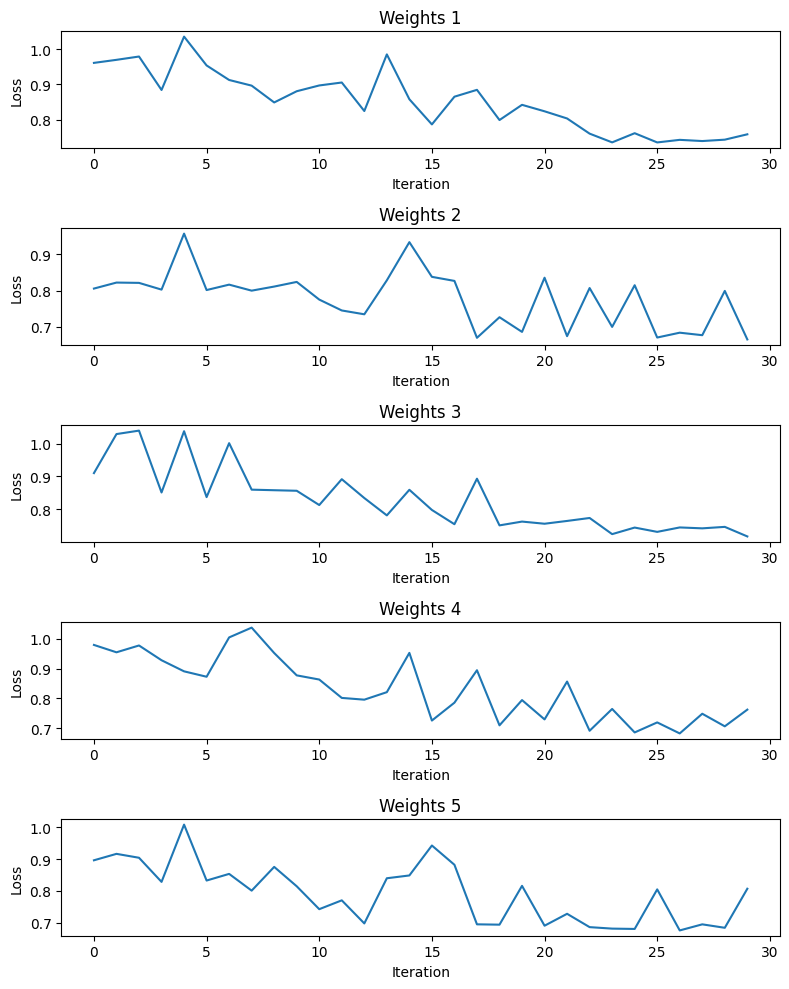

In [11]:
# Create a figure and axes for each array
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(8, 10))  # 5 rows, 1 column

# Loop through the arrays and plot each one
for i, loss in enumerate(losses):
    axes[i].plot(range(len(loss)), loss)
    axes[i].set_title(f'Weights {i + 1}')  # Set the title for each subplot
    axes[i].set_xlabel('Iteration')  # X-axis label
    axes[i].set_ylabel('Loss')   # Y-axis label

# Adjust layout
plt.tight_layout()
plt.show()

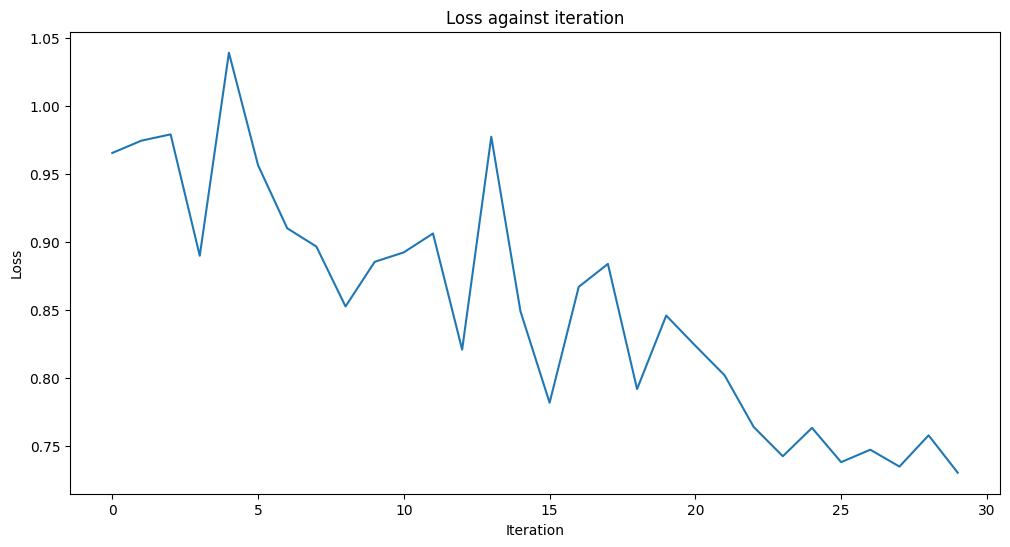

Training time: 97 seconds
Accuracy: 0.96


In [13]:
from IPython.display import clear_output

def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Loss against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

# Modify based on best accuracy
best_accuracy_weights = initial_weights[0]

classifier = NeuralNetworkClassifier(
    neural_network=sampler_qnn,
    loss="cross_entropy",
    one_hot=True,
    optimizer=COBYLA(maxiter=30),  #Default learning rate: 0.01
    initial_point=best_accuracy_weights, 
    callback=callback_graph
)

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
start = time.time()
classifier.fit(train_feats, train_labels)
elapsed = time.time() - start

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

print(f"Training time: {round(elapsed)} seconds")
accuracy = classifier.score(test_feats, test_labels)

print(f"Accuracy: {accuracy}")

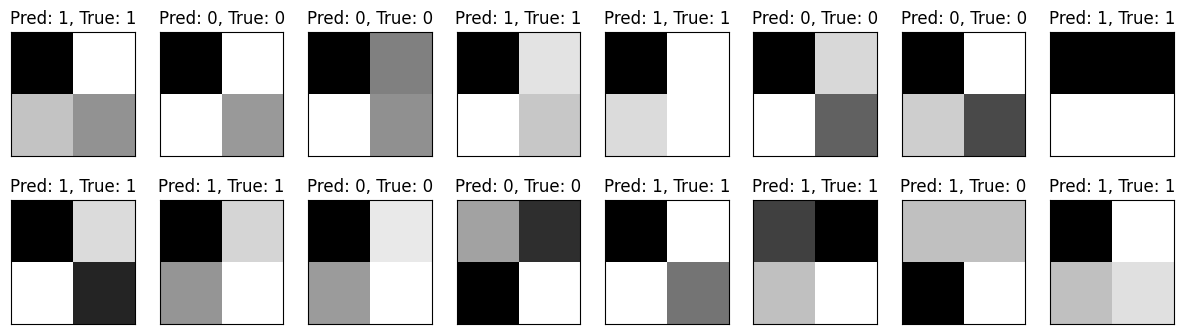

In [14]:
test_pred = classifier.predict(test_feats)

# Plot predicted labels
n_samples_show = 8
n_rows = 2
count = 0
fig, axes = plt.subplots(nrows=n_rows, ncols=n_samples_show, figsize=(15, 4))
for img, true, output in zip(test_imgs, test_labels, test_pred):
    if count == n_samples_show * n_rows:
        break
    
    pred = np.argmax(output)
    gt = np.argmax(true)
    row = count // n_samples_show  # Calculate row index
    col = count % n_samples_show  # Calculate column index

    im_np = img.transpose((1, 2, 0))
    axes[row, col].imshow(im_np, cmap="gray")

    axes[row, col].set_xticks([])
    axes[row, col].set_yticks([])
    axes[row, col].set_title("Pred: {}, True: {}".format(pred, gt))

    count += 1